In [1]:
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import json
from functools import partial
import numpy as np
from cachier import cachier
from tqdm import tqdm
import imageio
from skimage import img_as_float32
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean

## Load puzzle images, masks & corners

In [2]:
tqdm = partial(tqdm, position=0, leave=True)
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')

In [3]:
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'./data/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'./data/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array(
    [img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array(
    [img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])

assert DATA_IMGS.shape == (48, SIZE[0], SIZE[1], 3)
assert DATA_MSKS.shape == (48, SIZE[0], SIZE[1])

Loading Masks: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 219.20it/s]


In [4]:
with open(f'./data/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

In [5]:
def normalise_data(data):
    return np.subtract(data, np.min(data))/ np.subtract(np.max(data), np.min(data))

def show_image(image,cs=False,cmap= None, title=None):
    if cs:
        norm_img = normalise_data(image)
    else:
        norm_img = image
    plt.title(title)
    plt.imshow(norm_img, cmap= cmap)
    plt.xticks([])
    plt.yticks([])

# Feature extraction


In [177]:
class ImageFeatures(object):
    
    def _get_kernel(self, g, sigma, size, k=None):   
        """
        Function to map kernel function to numpy matrix, 
        Note result is normalized.
        
        """
        # Center x and y coordinates and return a numpy matrix from g function
        kernel =  np.fromfunction(lambda x, y: 
                                 g((x - (size - 1) / 2), (y - (size - 1) / 2), sigma, k),
                                 (size, size))  
        return kernel.astype(np.float32)

    def dog(self, sigma, size, k):
        """
        Get a Difference of Gaussian filter
    
        """
        def _g(x, y, sigma, k):
            return (2*pi*sigma**2) * \
                    e**(-1 * ((x**2 + y**2) / (2 * sigma**2))) - \
                    (1 / 2 * pi * k**2 * sigma**2) *\
                    e**(-1 * ((x**2 + y**2)/(2 * k**2 * sigma**2)))
                
        if k <= 1.0:
            raise ValueError("k must be > 1.0")
        
        return self._get_kernel(_g, sigma, size, k)
    
    def extract(self, image, gaus=(3,3), dog_sigma=10, dog_size=49, dog_k=5):
        """
        Parameters
        ----------
        image : numpy array
        gaus : tuple of gaussian kernel for blurring input image
        dog_sigma : int, sigma value for DoG features
        dog_size  : int, size of DoG kernel
        dog_k : int, k parameter for DoG 
        show_feature_plots : bool, verbose option to plot features
        
        Returns
        ---------- 
        numpy array : 9 x flattened image shape (786432) features of image.
        1 - 3: R, G, B channels
        4 - 6: DoG of RGB channels
        7 - 9: H, S, V channels
    
        """
        # Gaussian blur image as a first step to reduce noise
        image_ = cv2.GaussianBlur(image, gaus, 0).astype(np.float32)  
        # RBG Features
        features = None
        for rgb_channel in cv2.split(image_):
            if features is None:
                features = np.array(normalise_data(rgb_channel.flatten().astype(np.float32)))
            else:
                features = np.vstack((features, normalise_data(rgb_channel.flatten().astype(np.float32))))
                
        # DoG features
        dog_kernel = self.dog(dog_sigma, dog_size, dog_k)
        convolved = cv2.filter2D(image_, -1, dog_kernel)              
        for convolved_rgb_channel in cv2.split(convolved):
            features = np.vstack((features, normalise_data(convolved_rgb_channel.flatten().astype(np.float32))))

        # HSV features
        hsv_image = cv2.cvtColor(image_, cv2.COLOR_RGB2HSV)
        for hsv_channel in cv2.split(hsv_image):
            features = np.vstack((features, normalise_data(hsv_channel.flatten().astype(np.float32))))
  
        return features

## Multivariate gaussian to model a single puzzle piece
This is just to visualise the distribution for a single puzzle piece's foreground and background

In [178]:
def get_training_data(feature_data, mask, invert_mask = False):
    """
    Applies a mask to the data, and
    retrieves the pdf parameters for a single distribtution.

    """
    data = []
    mask_ = mask.astype(np.bool).flatten()
    if invert_mask:
        mask_ = np.invert(mask_)
    for feature in feature_data:
        masked_feature = feature[mask_ == True]
        # Append masked-normalised feature
        data.append(masked_feature.flatten())
    data = np.array(data)
    return data.T

**Foreground of first piece**

In [179]:
features_extractor = ImageFeatures()
features = features_extractor.extract(DATA_IMGS[0])
fg_data = get_training_data(features, DATA_MSKS[0], invert_mask=True)

**Background of first piece**

In [180]:
bg_data = get_training_data(features, DATA_MSKS[0])

## Gaussian Mixture model

Since our data is composed of intensities that might be modelled using gaussian distributions, we investigate the use of a Mixture Gausssian Model (GMM), which is an unsupervised learning approach that aims to fit a mixture of gasussian distributions to model the data with $d$ dimensions of features. And we want to use the GMM to fit clusters or mixture of gaussians to our data set, but we do not know where they are, or how they are shaped.
It differs from normal KNN, since the clusters are gaussian distributions, which are parameterised by a mean and covariance. Which allows us to model the probability that our data belongs to either clusters in elliptical shapes, as opposed to the circular shapes clustered by KNN.

![GMM](resources/GMM_illistration.png)

### Expectation Maximisation (EM)
We find the gaussian mixture model by using the EM algorithm to find k to minimize $\frac{(x-u_k)^2}{\sigma^2}$.
EM introduces a latent variable $h$ for each cluster $K$, and the GMM is a marginalisation of the joint probability distribution $P(\vec{x}, h)$, where $\vec{x}$ represents our feature vectors.  We define a variable $h \in \{1 \dots K\}$ and then the probability distribution for each categorical variable is written as <br>
$Pr(\times|h, \theta) = Norm_x[\mu_h, \Sigma_h]$ <br>
$Pr(h|\theta) = Cat_h[\lambda]$ <br>

Then we can recover the density by marginalising out the $h$ from the joint probability distribution $Pr(\vec{x},h)$ <br>
$
\begin{align}
Pr(\vec{x}|\theta) & = \sum^K_{k=1} Pr(\vec{x}, h = k | \theta)\\
                   & = \sum^K_{k=1} Pr(\vec{x}, h = k, \theta) Pr(h=k|\theta)\\
                   & = \sum^K_{k=1} \lambda_k Norm_\vec{x}[\mu_k, \Sigma_h]   \\
\end{align}
$

![GMM](resources/GMM_marginilisation.png)

This formulation allows us to fit the model with the Expectation Maximisation algorithm using closed-form solutions in an iterative process. The goal is to learn the model parameters $\theta = \{\lambda_{1 \dots K}, \mu_{1 \dots K}, \Sigma_{1 \dots K} \}$ from our training features $\vec{x}$. The two steps of the EM algorithm include

#### 1. E-Step (Expectation)
The probability of $h$ is computed using the current estimates of the parameters $\theta$. So for each point we estimate the probability that each Gaussian generated it $Pr(h_i = k | \vec{x}_i, \theta^{[t]})$, which might also be described as the responsibility of the $k^{th}$ Gaussian for the $i^{th}$ data point expressed by <br>
$r_{ik} = \frac{\lambda_k Norm_{x_i} [\mu_k, \Sigma_k]}{\sum^K_{j=1}\lambda_j Norm_\vec{x_i} [\mu_j, \Sigma_j]}$

![GMM](resources/GMM_Estep.png)


#### 1. M-Step (Maximisation)
Using the computed resposibilities the maximisation step then updates the model parameters $\theta$. And in our case we use maximum likelihood estimation that allows the following closed form update rules <br>


$\lambda_k^{[t + 1]} = \frac{\sum^I_{i=1} r_{ik}} {\sum^K_{j=1}\sum^I_{i=1} r_{ij}  }   $

$\mu_k^{[t + 1]} = \frac{\sum^I_{i=1} r_{ik} \vec{x_i}} {\sum^I_{i=1} r_{ik}} $

$\Sigma_k^{[t + 1]} = \frac{\sum^I_{i=1} r_{ik} (\vec{x_i} - \mu_k^{[t + 1]}) (\vec{x_i} - \mu_k^{[t + 1]})^T}{\sum^I_{i=1} r_{ik}}$

![GMM](resources/GMM_Mstep.png)

#### The EM-flow
![EM](resources/EM_flow.png)
- The $k$ clusters center are randomly initialised 
- The responsibilities are recomputed during the E-Step, and the model parameters are updated during the M-Step.
- The iterative process is repeated until convergence (Parameter change is smaller then some threshold.)


In [305]:
class GuassianParameters(object):
    """Distribution parameters"""

    def __init__(self, lmbda, mu, cov):
        self.lmbda = lmbda
        self.mu = mu
        self.cov = cov

    def difference_between(self, other):
        return abs(self.lmbda - other.lmbda) + \
               euclidean(self.mu, other.mu) + \
               euclidean(self.cov.flatten(), other.cov.flatten())


class GaussianMixtureModel(object):
    """Multivariate Gaussian Mixture Model"""

    def _get_init_params(self, X):
        n_features = X.shape[1]
        # Initial weigths evenly distributed
        lmbda = 1 / self.k_size
        # Initial means, random observations from input data
        mu = np.random.choice(X.flatten(), n_features)
        # Iniital covariance
        cov = np.random.random((n_features, n_features))
        cov *= cov.T
        cov += n_features * np.eye(n_features)
        return GuassianParameters(lmbda, mu, cov)

    def __init__(self, n_k=3, n_runs=5, tol=1e-4, max_iter=100, verbose=True):
        self.fitted = False
        self.k_size = n_k
        self.n_runs = n_runs
        self.tol = tol
        self.max_iter = max_iter
        self.verbose = verbose
        self.fitted_parameters = None

    def _estep(self, X, gaussian_parameters):
        """Calculate the responsibility for each cluster for all of the data points,"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.k_size))
        weighted_gaussians = np.zeros((n_samples, self.k_size))
        # Get normal distributions using current parameter set
        for k in range(self.k_size):
            weighted_gaussians[:, k] = gaussian_parameters[k].lmbda * \
                                       multivariate_normal.pdf(X, gaussian_parameters[k].mu, gaussian_parameters[k].cov)
        # Compute responsibility for each cluster
        for k in range(self.k_size):
            responsibilities[:, k] = weighted_gaussians[:, k] / np.sum(weighted_gaussians, axis=1, initial=1e-10)
        return responsibilities

    def _mstep(self, X, responsibilities):
        """Compute model parameters using maximum likelikhood closed form solutions"""
        gaussian_parameters = []
        for k in range(self.k_size):
            k_sum_responsibility = np.sum(responsibilities[:, k])
            lmbda = k_sum_responsibility / (np.sum(np.sum(responsibilities, axis=1)))
            mu = np.dot(responsibilities[:, k], X) / k_sum_responsibility
            standardised_x = X - mu
            cov = np.dot((standardised_x.T * responsibilities[:, k]), standardised_x) / k_sum_responsibility
            # Add small value to diagonal to prevent singular matrix
            cov += np.eye(len(cov)) * 1e-10
            gaussian_parameters.append(GuassianParameters(lmbda, mu, cov))
        return gaussian_parameters

    def fit(self, X):
        """Fit the model according to the given training data.

        Parameters
        ----------
        X : numpy array, of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples/pixels and
            n_features is the number of features.

        """
        converged = False
        run_iteration = 1
        # Initialise parameters
        gaussian_parameters = [self._get_init_params(X) for _k in range(self.k_size)]
        while not converged and run_iteration <= self.max_iter:
            # E-step
            responsibilities = self._estep(X, gaussian_parameters)
            # M-step
            new_gaussian_parameters = self._mstep(X, responsibilities)
            # Iterate until parameters experience change smaller than tolerance
            total_change = 0
            for k, parameters in enumerate(new_gaussian_parameters):
                total_change += parameters.difference_between(gaussian_parameters[k])
            if total_change < self.tol:
                converged = True
            gaussian_parameters = new_gaussian_parameters
            if self.verbose:
                print("Iteration #{0}, change in parameters {1}".format(run_iteration, total_change))
            run_iteration += 1
            
        self.fitted_parameters = gaussian_parameters
        self.fitted = True
        
        if self.verbose:
            print("Finished in {0} iterations".format(run_iteration - 1))
            
    def predict(self, X):
        """ Predict's the probability density the input observations by marginalising
        out the joint probability distributions.
        
        Parameters
        ----------
        X : numpy array, of shape (n_samples, n_features)
            Testing vector, where n_samples is the number of samples/pixels and
            n_features is the number of features.
        
        Returns
        ----------
        y : numpy array, of shape (n_samples)
            Estimated probability density from the mixture of gaussian models.
        """
        assert self.fitted, "Model is not yet fitted."
        n_samples = X.shape[0]
        gaussian_pdfs = np.zeros((n_samples, self.k_size))
        for k in range(self.k_size):
            gaussian_pdfs[:, k] = self.fitted_parameters[k].lmbda *\
            multivariate_normal.pdf(X, self.fitted_parameters[k].mu, self.fitted_parameters[k].cov)
        return np.sum(gaussian_pdfs, axis=1)

In [306]:
bg_gmm = GaussianMixtureModel()

In [307]:
bg_gmm.fit(bg_data)

Iteration #1, change in parameters 86.78486886210865
Iteration #2, change in parameters 0.048852571379784306
Iteration #3, change in parameters 0.24146411450648414
Iteration #4, change in parameters 0.7341891267436587
Iteration #5, change in parameters 0.33987194003847276
Iteration #6, change in parameters 0.2490303534813161
Iteration #7, change in parameters 0.08862317168041003
Iteration #8, change in parameters 0.05040095695188027
Iteration #9, change in parameters 0.05785165006748533
Iteration #10, change in parameters 0.037719199204924794
Iteration #11, change in parameters 0.025459351060073614
Iteration #12, change in parameters 0.017447920462190007
Iteration #13, change in parameters 0.011821873492042057
Iteration #14, change in parameters 0.008284855519583917
Iteration #15, change in parameters 0.006061208611136909
Iteration #16, change in parameters 0.00459335768169061
Iteration #17, change in parameters 0.003570511257021504
Iteration #18, change in parameters 0.002818826514017

In [308]:
fg_gmm = GaussianMixtureModel()

In [309]:
fg_gmm.fit(fg_data)

Iteration #1, change in parameters 87.43231049940185
Iteration #2, change in parameters 0.0335382575248943
Iteration #3, change in parameters 0.18871187532155315
Iteration #4, change in parameters 0.5387847121145284
Iteration #5, change in parameters 0.3661688243310085
Iteration #6, change in parameters 0.18915660613554253
Iteration #7, change in parameters 0.11655352078391654
Iteration #8, change in parameters 0.07278904508064482
Iteration #9, change in parameters 0.06790504819557583
Iteration #10, change in parameters 0.06428643003174347
Iteration #11, change in parameters 0.06328724259818112
Iteration #12, change in parameters 0.070107731524067
Iteration #13, change in parameters 0.08358815215651837
Iteration #14, change in parameters 0.1289837113546957
Iteration #15, change in parameters 0.19478864460677797
Iteration #16, change in parameters 0.22304386467502874
Iteration #17, change in parameters 0.19010102449983157
Iteration #18, change in parameters 0.12041195113367315
Iteration

In [310]:
bg_densities = bg_gmm.predict(features.T)

In [312]:
fg_densities = fg_gmm.predict(features.T)

In [321]:
test = fg_densities / (0.4*fg_densities + 0.3*bg_densities + 1e-10) 

In [325]:
pop = test < 0.5

In [326]:
pop = pop.astype(int).reshape(SIZE)

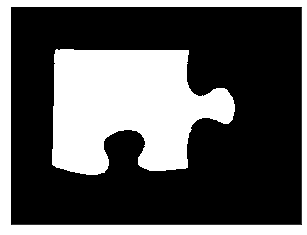

In [327]:
show_image(pop, cmap='gray')